<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/Airline_(ML)_No_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-15 10:23:08--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-07-15 10:23:08 (24.4 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:
df = pd.read_csv('airline.csv', index_col="Month", parse_dates=True)
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.shape

(144, 1)

<Axes: xlabel='Month'>

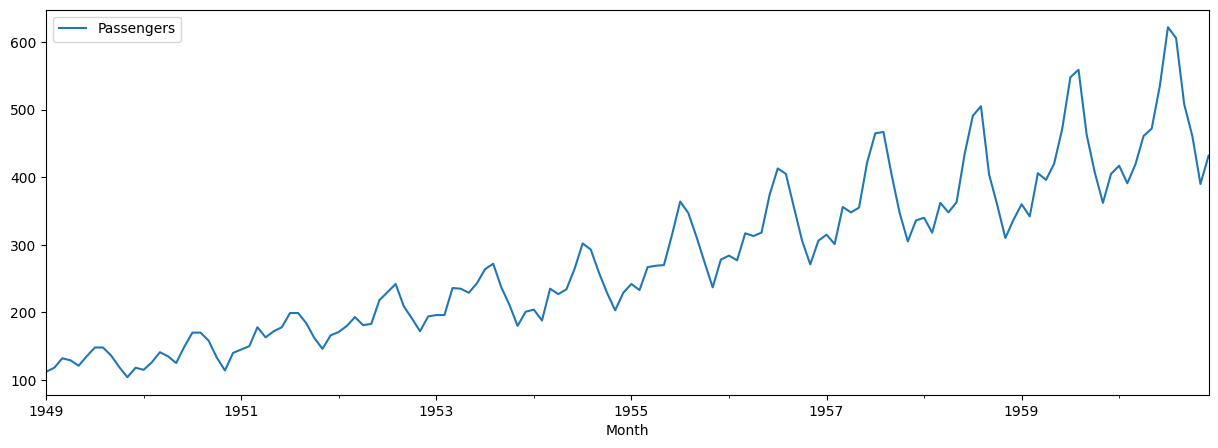

In [ ]:
df.plot(figsize=(15,5))

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])
df.head()

,Passengers,LogPassengers
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


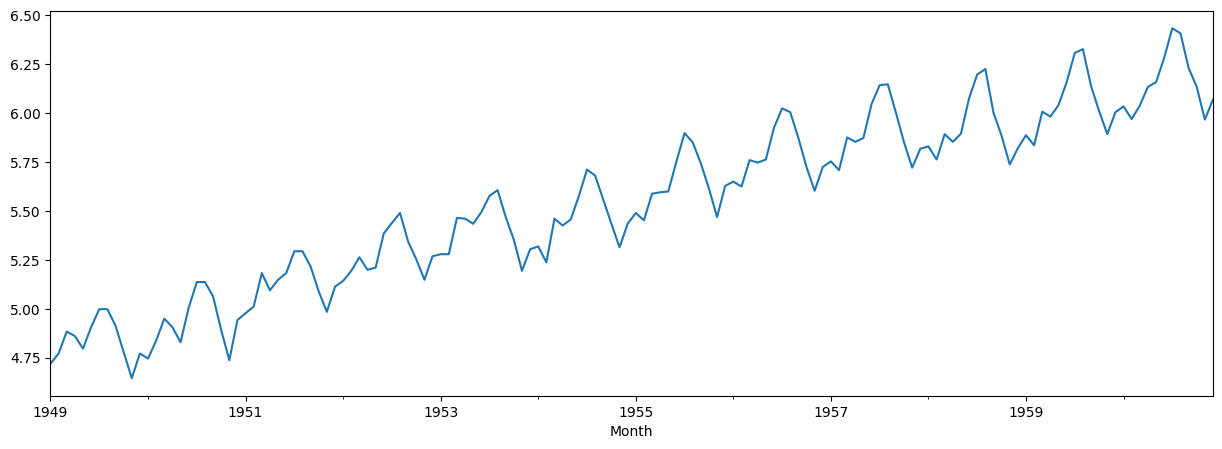

In [ ]:
df['LogPassengers'].plot(figsize=(15,5));

In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

 Let's prepare our data for regression problem. <br> we will use lags = 10.

In [ ]:
series = df['LogPassengers'].to_numpy()
T = 10
X = []
Y = []

for t in range(len(series) - T):
  # print("T is: ", t)
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X = X.reshape(-1, T)
print(X.shape)
print(Y.shape)

(134, 10)
(134,)


In [ ]:
X_train, X_test = X[:-N_test], X[-N_test:]
Y_train, Y_test = Y[:-N_test], Y[-N_test:]

#### Let's fit the Linear Regressor

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_train, Y_train)

0.9599443783339897

In [ ]:
lr.score(X_test, Y_test)

0.6910953044565584

As you can see that it works pretty well on train data but not works good on test data

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
train_idx[:T] = False

In [ ]:
df.loc[train_idx, '1step LR Train'] = lr.predict(X_train)
df.loc[test_idx, '1step LR Test'] = lr.predict(X_test)

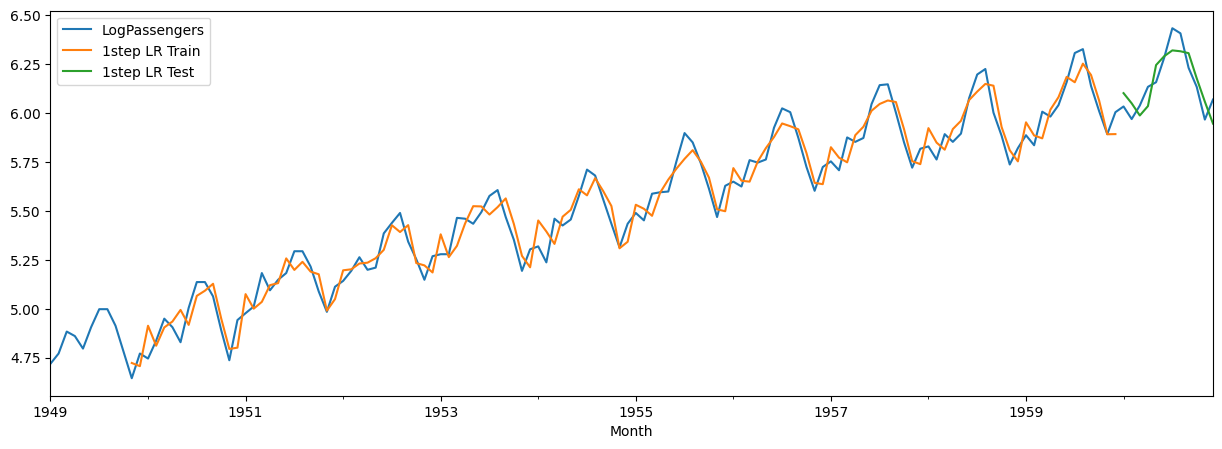

In [ ]:
# Let's plot it.
df[['LogPassengers', '1step LR Train', '1step LR Test']].plot(figsize=(15,5));

As we can see that it struggle more in predicting the peak values

##### Now let's do multi-step forecast which is not possible in stats models

In [ ]:
multisper_prediction = []

last_x = X_test[0]
while len(multisper_prediction) < N_test:
  p = lr.predict(last_x.reshape(1, -1))[0]
  multisper_prediction.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
df.loc[test_idx, 'Multistep LR Test'] = multisper_prediction

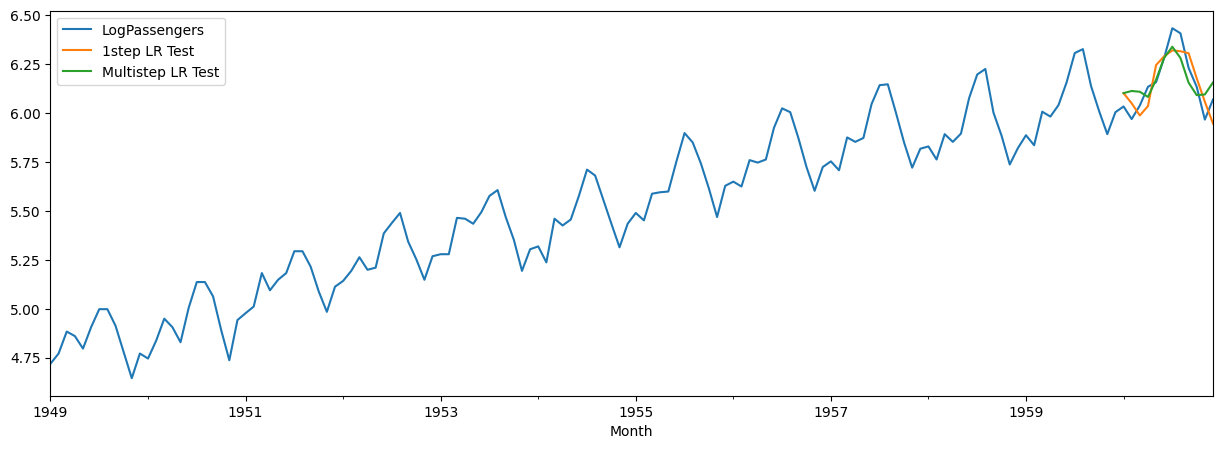

In [ ]:
# Plot results
df[['LogPassengers', '1step LR Test', 'Multistep LR Test']].plot(figsize=(15,5));

### Let's do Multi-Output Forecast

In [ ]:
T = 10
Ty = N_test
X = []
Y = []

for t in range(len(series) - T - Ty + 1):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T:t+T+Ty]
  Y.append(y)

In [ ]:
X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, Ty)
print("X_shape: ", X.shape, " Y_Shape: ", Y.shape)

X_shape:  (123, 10)  Y_Shape:  (123, 12)


In [ ]:
X_train_m, X_test_m = X[:-1], X[-1:]
Y_train_m, Y_test_m = Y[:-1], Y[-1:]

In [ ]:
X_test_m.shape

(1, 10)

In [ ]:
# Let's fit the model
lr = LinearRegression()
lr.fit(X_train_m, Y_train_m)
lr.score(X_train_m, Y_train_m)

0.9734607773512526

In [ ]:
lr.score(X_test_m, Y_test_m)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

As it is nan, because it is a single value, so can't be calculated for a single value.

In [ ]:
r2_score(lr.predict(X_test_m).flatten(), Y_test_m.flatten())

0.8018749676715242

In [ ]:
# Let's save the prediction in df
df.loc[test_idx, 'Multi-output LR Test'] = lr.predict(X_test_m).flatten()

NameError: name 'lr' is not defined

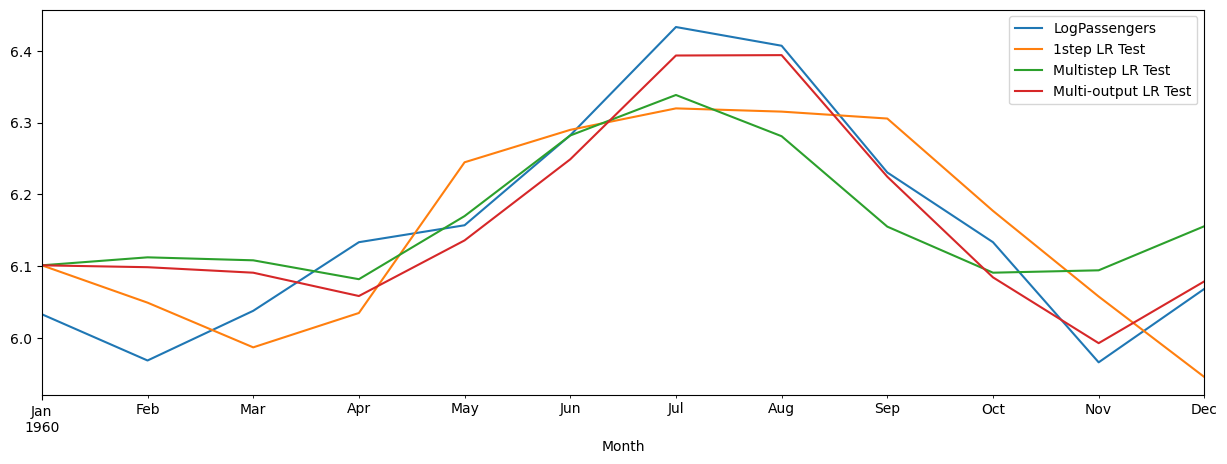

In [ ]:
# Let's plot all of them
fig, ax = plt.subplots(figsize=(15,5))
df[['LogPassengers', '1step LR Test', 'Multistep LR Test', 'Multi-output LR Test']][-N_test:].plot(ax=ax);

As we can see that the multi output is the best one

#### Let's calculate the mean absolute percentage error now

In [ ]:
mape_1step = mean_absolute_percentage_error(df.loc[test_idx, '1step LR Test'], df.loc[test_idx, 'LogPassengers'])
mape_multistep = mean_absolute_percentage_error(df.loc[test_idx, 'Multistep LR Test'], df.loc[test_idx, 'LogPassengers'])
mape_multioutput = mean_absolute_percentage_error(df.loc[test_idx, 'Multi-output LR Test'], df.loc[test_idx, 'LogPassengers'])
print("1step: ", mape_1step, "Multistep: ", mape_multistep, "Multioutput: ", mape_multioutput)


1step:  0.012642291425128358 Multistep:  0.01217906415806057 Multioutput:  0.007146427688153024


In [ ]:
# Let's create method for 1 step and multistep forecast.
def onestep_and_multistep_forecast(model, name):
  """
  modle = The model we use
  name = Model name which is prepended for column name
  """
  model.fit(X_train, Y_train)

  df.loc[train_idx, f"{name}_1step_train"] = model.predict(X_train)
  df.loc[test_idx, f"{name}_1step_test"] = model.predict(X_test)

  multistep_prediction = []

  last_x = X_test[0]
  while len(multistep_prediction) < N_test:
    p = model.predict(last_x.reshape(1, -1))[0]

    multistep_prediction.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  df.loc[test_idx, f"{name}_multistep_test"] = multistep_prediction

  mape = mean_absolute_percentage_error(Y_test, multistep_prediction)
  print(f"{name} MAPE: ", mape)

  cols = ['LogPassengers', f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test"]
  df[cols].plot(figsize=(15,5));

SVR MAPE:  0.017529446164230467


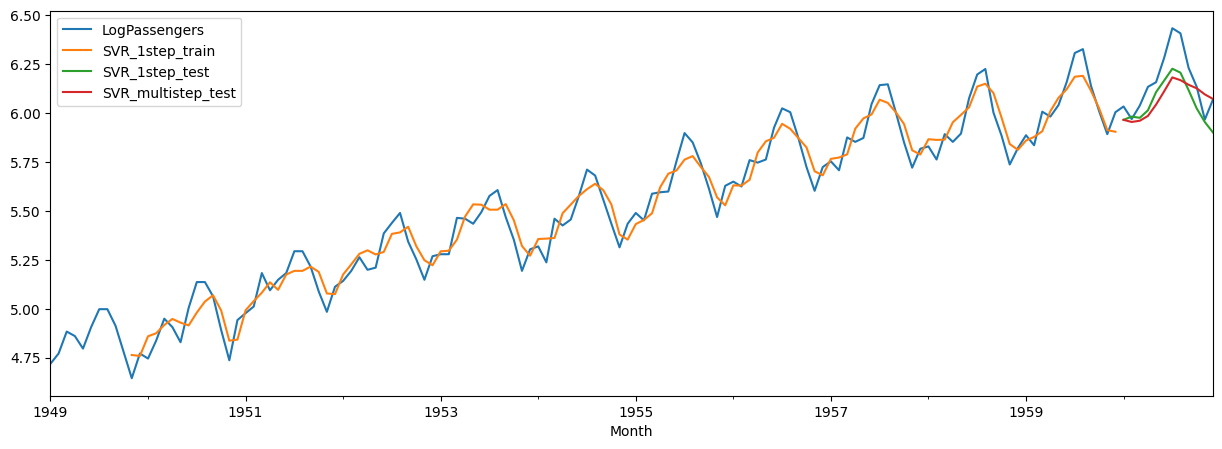

In [ ]:
# Let's try SVM
onestep_and_multistep_forecast(SVR(), "SVR")

This has done worse than linear regression

#### Let's try Random Forest

Random Forest MAPE:  0.0174260228719834


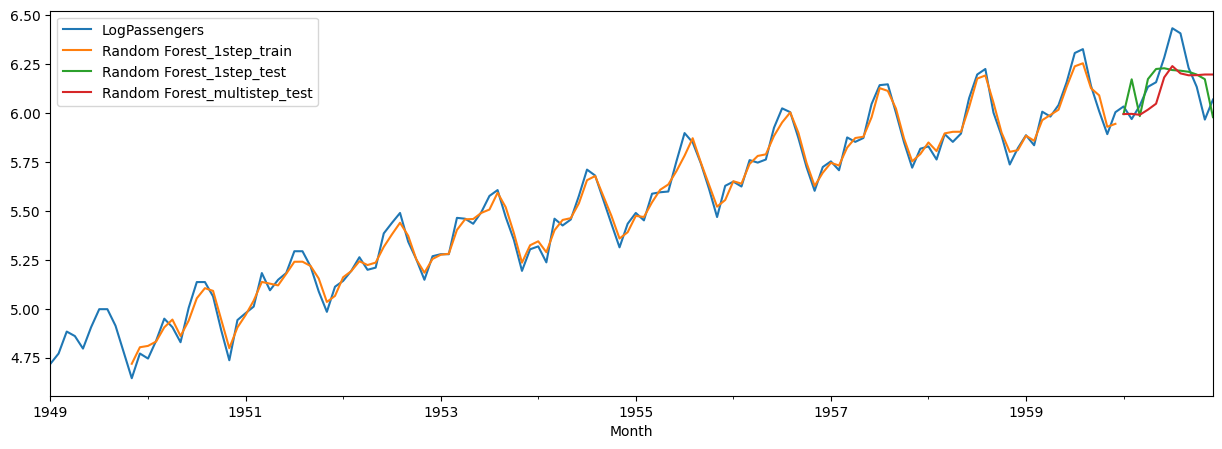

In [ ]:
onestep_and_multistep_forecast(RandomForestRegressor(), "Random Forest")

It seems that this also don't work well.

In [ ]:
# Let's have a method for multi output forecast
def multi_output_forecast(model, name):
  model.fit(X_train_m, Y_train_m)

  df.loc[test_idx, f"{name}_multioutput_test"] = model.predict(X_test_m).flatten()

  mape = mean_absolute_percentage_error(Y_test, df.loc[test_idx, f"{name}_multioutput_test"])
  print(f"{name} MAPE: ", mape)

  cols = ['LogPassengers', f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test",  f"{name}_multioutput_test"]
  df[cols].plot(figsize=(15,5));

In [ ]:
# The below code will not work which indicate the SVR will not work for multi output forecast
#multi_output_forecast(SVR(), "SVR")

Random Forest MAPE:  0.016197392890184067


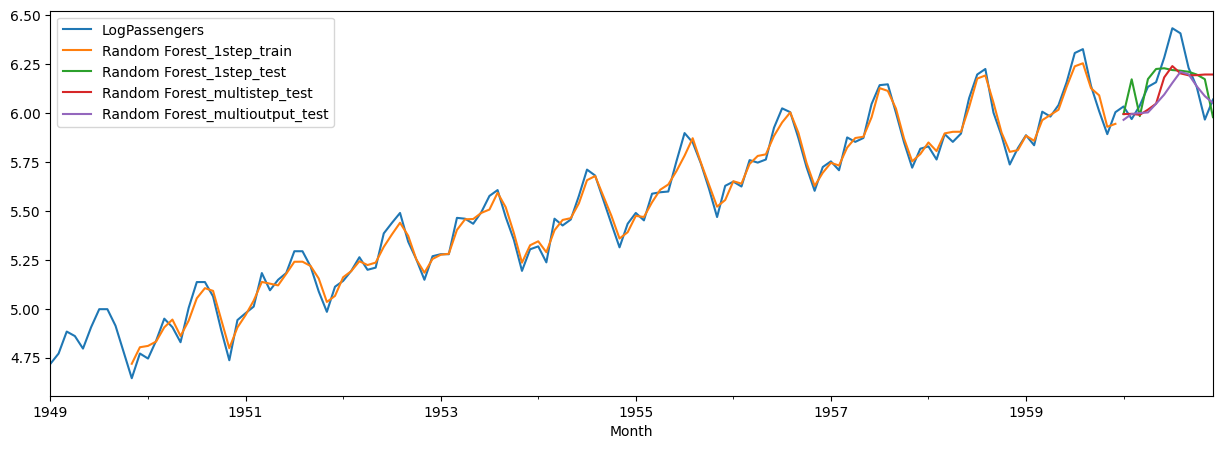

In [ ]:
multi_output_forecast(RandomForestRegressor(), "Random Forest")